In [12]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D


In [7]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

In [43]:
from pickletools import optimize


model = tf.keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))

model.add(MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax')) #alle zusammen = 1 jedes neuron hat eine Zahl zwischen 0 und 1. Probality of each digit

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])
model.fit(x_train, y_train, epochs= 10)
model.save('handwritten.model')


Epoch 1/10
1875/1875 [==============================] - 20s 11ms/step - loss: 2.7218 - accuracy: 0.8843
Epoch 2/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2902 - accuracy: 0.9482
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1986 - accuracy: 0.9581
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1357 - accuracy: 0.9675
Epoch 5/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1021 - accuracy: 0.9744
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0785 - accuracy: 0.9794
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0607 - accuracy: 0.9840
Epoch 8/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0467 - accuracy: 0.9872
Epoch 9/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0412 - accuracy: 0.9884
Epoch 10/10
1875/1875 [==============================] - 22s 12m

INFO:tensorflow:Assets written to: handwritten.model\assets


INFO:tensorflow:Assets written to: handwritten.model\assets


In [44]:
model = tf.keras.models.load_model('handwritten.model')
loss, accuracy = model.evaluate(x_test, y_test)

print(loss)
print(accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.1153 - accuracy: 0.9789
0.1153472289443016
0.9789000153541565


In [66]:
def predicthandwritten(path): 
 img = cv2.imread(path)[:,:,0]
 img = np.invert(np.array([img]))
 prediction = model.predict(img)
 print(prediction)
    
 plt.imshow(img[0])
 plt.show()
 print(np.argmax(prediction))
 



1/1 [==============================] - 0s 17ms/step
[[5.7975584e-09 1.5688590e-06 1.0263707e-05 9.5735949e-01 1.5950603e-07
  4.0826946e-02 2.4908001e-08 1.6019018e-07 2.1873835e-04 1.5826529e-03]]


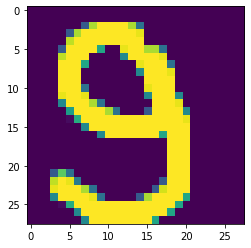

3


In [76]:
predicthandwritten("9.png")